In [11]:
import sys
sys.path.append('../')

from nEXO_loader import loader
from waveform_fit import fitter
import numpy as np

In [13]:
nexo_loader = loader()
#nexo_loader.filename = '/Users/yumiao/Documents/Works/0nbb/nEXO/offline-samples/bb0n_withPCDs/Baseline2019_bb0n_X0Y0Z-400mm_seed223_comsol.nEXOevents.root'
nexo_loader.filename = '/Users/yumiao/Documents/Works/0nbb/nEXO/offline-samples/Baseline2019_bb0n_FullLXe_seed52_comsol.nEXOevents.root'
nexo_loader.load_nentries = 10
nexo_loader._load_event()


['SimEvent', 'SimEvent/nEXO::EventObject', 'SimEvent/nEXO::EventObject/TObject', 'SimEvent/nEXO::EventObject/TObject/fUniqueID', 'SimEvent/nEXO::EventObject/TObject/fBits', 'SimEvent/fGenTheta_p', 'SimEvent/fGenPhi_p', 'SimEvent/fGenE', 'SimEvent/fParentTrackID', 'SimEvent/fNeutronCount', 'SimEvent/fXe137Count', 'SimEvent/fInitNeutronEnergy', 'SimEvent/fPMT_Hits', 'SimEvent/fPMTID', 'SimEvent/fPMTs_fired', 'SimEvent/fmu_Impact_parameter', 'SimEvent/fn_Impact_parameter', 'SimEvent/fTotalEventEnergy_WT', 'SimEvent/fEnergyDeposit_WT', 'SimEvent/fLengthDeposit_WT', 'SimEvent/fNumDeposits_WT', 'SimEvent/fEventNumber', 'SimEvent/fGenX', 'SimEvent/fGenY', 'SimEvent/fGenZ', 'SimEvent/fGenParticleID', 'SimEvent/fGenKineticE', 'SimEvent/fTotalEventEnergy', 'SimEvent/fNumDeposits', 'SimEvent/fLengthDeposit', 'SimEvent/fEnergyDeposit', 'SimEvent/fPreEnergyDeposit', 'SimEvent/fPostEnergyDeposit', 'SimEvent/fTrackNumber', 'SimEvent/fXpos', 'SimEvent/fYpos', 'SimEvent/fZpos', 'SimEvent/fTglob', 'SimE

In [3]:
# load PCD truths from MC:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/yumiao/Documents/Works/0nbb/nEXO/offline-samples/bb0n_withPCDs/Baseline2019_bb0n_X0Y0Z-400mm_seed223_comsol.nEXOevents.out')
truth_PCD_NTE = df['TE'].to_numpy()
truth_PCD_x = df['x'].to_numpy()
truth_PCD_y = df['y'].to_numpy()
truth_PCD_z = df['z'].to_numpy()

unique_XYcomb = np.column_stack((truth_PCD_x, truth_PCD_y))
unique_indices, inverse_indices = np.unique(unique_XYcomb, axis=0, return_inverse=True)
X0 = unique_indices[:, 0]
Y0 = unique_indices[:, 1]
E0 = np.zeros_like(X0, dtype=truth_PCD_NTE.dtype)
np.add.at(E0, inverse_indices, truth_PCD_NTE)

264.1264183552314 -100.46250505307238 -1093.7490559640953
Passing time is 391.75 us, the rough drift distance is 665.975 mm.


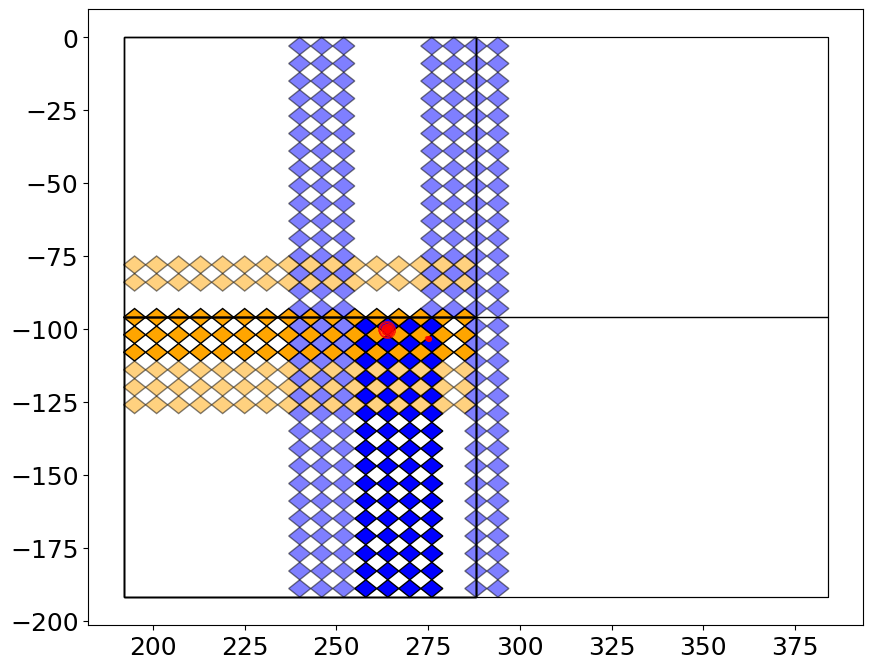

In [18]:
evtid = 0
one_event = nexo_loader._get_one_event(evtid)
#print(one_event.keys())
indices = np.argsort(one_event['event_E'])
#print(one_event['event_x'][indices[-4::]])
#print(one_event['event_y'][indices[-4::]])
#print(one_event['event_E'][indices[-4::]])

nexo_loader._plot_topo2d(evtid, truthDepPos=True, truthPCD=False, PCDs=[X0, Y0, E0/100.])

recz = nexo_loader.Simple_Zrec(evtid)

In [19]:
times_coll, wfs_coll, strip_x_coll, strip_y_coll, ystrips_coll, qs_coll, tag_coll = nexo_loader.assembling_for_fitter(evtid, strip_type='coll')
print(f'{len(strip_x_coll)} collection channels in this event.')

xpos_all, ypos_all = nexo_loader.scanning_points(strip_x_coll, strip_y_coll, ystrips_coll)
seen = set()
duplicates = set()
for xi, yi in zip(xpos_all, ypos_all):
    pair = (xi, yi)
    if pair in seen:
        duplicates.add(pair)
    else:
        seen.add(pair)
xpos, ypos = zip(*[(xi, yi) for xi, yi in zip(xpos_all, ypos_all) if (xi, yi) not in duplicates])
print(f'Total {len(xpos_all)} crossing pads to be fitted, {len(xpos)} after duplication checks.')

times, wfs, strip_x, strip_y, ystrips, qs, tag = nexo_loader.assembling_for_fitter(evtid, strip_type='all')
print(f'{len(strip_x)} collection+induction channels in this event.')


xpos_fine_all, ypos_fine_all = nexo_loader.scanning_points_fine(strip_x_coll, strip_y_coll, ystrips_coll)
seen = set()
duplicates = set()
for xi, yi in zip(xpos_fine_all, ypos_fine_all):
    pair = (xi, yi)
    if pair in seen:
        duplicates.add(pair)
    else:
        seen.add(pair)
xpos_fine, ypos_fine = zip(*[(xi, yi) for xi, yi in zip(xpos_fine_all, ypos_fine_all) if (xi, yi) not in duplicates])
print(f'Total {len(xpos_fine)} fine points to be scanned in this event.')


10 collection channels in this event.
[42.0, 48.0, 54.0, 48.0, 54.0] [-42.0, -42.0, -42.0, 54.0, 54.0]
[0.0, 0.0, 96.0, 96.0, 96.0] [0.0, 6.0, 0.0, 6.0, 12.0]
Total 100 crossing pads to be fitted, 2 after duplication checks.
38 collection+induction channels in this event.
[42.0, 48.0, 54.0, 48.0, 54.0] [-42.0, -42.0, -42.0, 54.0, 54.0]
[0.0, 0.0, 96.0, 96.0, 96.0] [0.0, 6.0, 0.0, 6.0, 12.0]
Total 16 fine points to be scanned in this event.


In [10]:
# filtering the input PCDs with charget > cut (>1%?)
truth_PCD_NTE_filtered = truth_PCD_NTE[truth_PCD_NTE > np.sum(truth_PCD_NTE)*0.01]
truth_PCD_x_filtered = truth_PCD_x[truth_PCD_NTE > np.sum(truth_PCD_NTE)*0.01]
truth_PCD_y_filtered = truth_PCD_x[truth_PCD_NTE > np.sum(truth_PCD_NTE)*0.01]
truth_PCD_z_filtered = truth_PCD_x[truth_PCD_NTE > np.sum(truth_PCD_NTE)*0.01]

print(len(truth_PCD_NTE), len(truth_PCD_NTE_filtered))

926 19


In [21]:
import numpy as np

zpos = [recz for i in range(len(xpos_fine))]
Q0s = np.random.uniform(0, 0.5, len(xpos_fine))
print(Q0s)
t0 = np.zeros(len(xpos))

n_param = 2 #4
init_par = []
for i in range(len(xpos_fine)):
    #init_par.append(xpos[i])
    #init_par.append(ypos[i])
    init_par.append(zpos[i])
    init_par.append(Q0s[i])
    
print(f'==> Total {len(init_par)/n_param:.0f} cluster are considered in this event.')

[0.10077401 0.32851249 0.10016556 0.07296312 0.01597979 0.28944288
 0.48855361 0.1028494  0.32516346 0.11256907 0.28187851 0.31071867
 0.37386857 0.40655235 0.07640606 0.48563978 0.08612151 0.11641344
 0.32812528 0.26169612 0.30941321 0.41199694 0.30072554 0.28841904
 0.12409622 0.08672956 0.08884845 0.42385256 0.00403012 0.45341933
 0.03806628 0.34695874 0.36308483 0.01869397 0.15439418 0.22905849
 0.47669439 0.10504204 0.43840075 0.42808501]
==> Total 40 cluster are considered in this event.


In [22]:
import sys
sys.path.append('../')

from waveform_fit import fitter
fit = fitter(SamplingFrequency=2.0)

fit.load_gridPDFs()

  0%|          | 0/2 [00:00<?, ?it/s]

During minuit construction, there are 40 clusters.
W VariableMetricBuilder Call limit exceeded
W VariableMetricBuilder FunctionMinimum is invalid, reached function call limit
Parameters : [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 78, 79]  are fixed in this fitting routine.
During minuit construction, there are 40 clusters.
Parameters : [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 78, 79]  are fixed in this fitting routine.


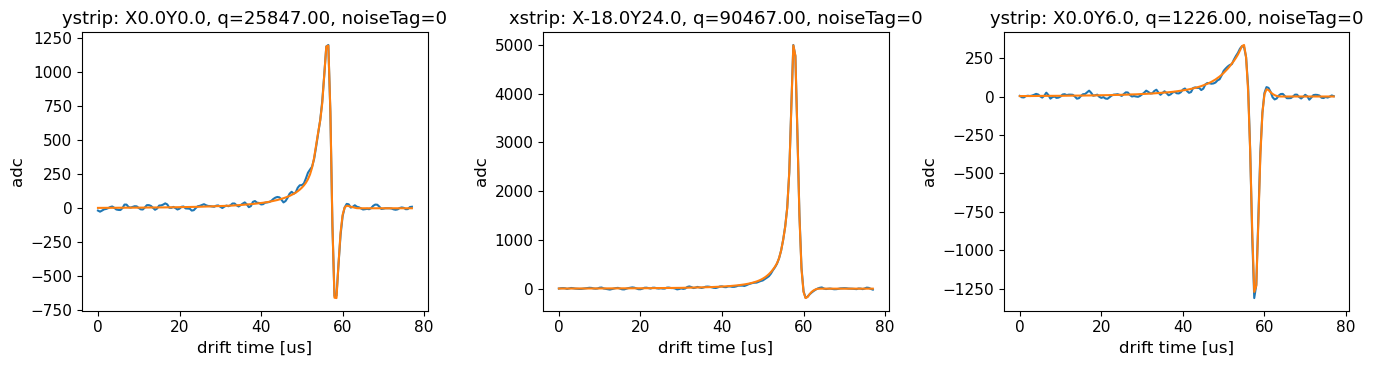

In [23]:
from tqdm.notebook import tqdm
n_param = 2
fixedPar = []
for i in tqdm(range(2)):
    m_coll = fit.multiCluster_fitting(times_coll, wfs_coll, xpos_fine, ypos_fine, init_par, strip_x_coll, strip_y_coll, ystrips_coll, fixedNo=fixedPar)
    init_par = m_coll.values

    fixedPar = []
    for ipar in range(int(len(init_par)/n_param)):
        val = init_par[ipar*n_param+1]
        if val < 1e-2:
            init_par[ipar*n_param+1] = 0.0 # set charge as 0 if it is too small
            fixedPar.append(ipar*n_param+0)
            fixedPar.append(ipar*n_param+1)
    print('Parameters ', end=': ')
    print(fixedPar, end=' ')
    print(' are fixed in this fitting routine.')

fit_params = m_coll.values
fit.multiCluster_manualtuning(times_coll, wfs_coll, xpos_fine, ypos_fine, fit_params, strip_x_coll, strip_y_coll, ystrips_coll, qs_coll, tag_coll)

In [24]:
m_coll

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 706.7                      │             Nfcn = 3572              │
│ EDM = 0.000149 (Goal: 0.0002)    │           time = 49.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   83.4    │    0.8    │            │            │ 63.4356 │ 103.436 │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 2 │ x2   │   90.4    │    0.9    │            │            │ 70.3874 │ 110.387 │  yes  │
│ 3 │ x3   │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 4 │ x4   │   89.31   │   0.10    │            │            │ 69.519  │ 109.519 │       │
│ 5 │ x5   │  0.0268   │  0.0021   │            │            │    0    │    2    │       │
│ 6 │ x6   │   103.5   │    1.0    │            │            │ 83.4886 │ 123.489 │  yes  │
│ 7 │ x7   │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 8 │ x8   │   70.6    │    0.7    │            │            │ 50.6295 │ 90.6295 │  yes  │
│ 9 │ x9   │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 10│ x10  │   94.5    │    0.9    │            │            │ 74.5287 │ 114.529 │  yes  │
│ 11│ x11  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 12│ x12  │   92.45   │   0.15    │            │            │ 72.8004 │  112.8  │       │
│ 13│ x13  │   0.039   │   0.008   │            │            │    0    │    2    │       │
│ 14│ x14  │   105.5   │    1.0    │            │            │ 85.4931 │ 125.493 │  yes  │
│ 15│ x15  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 16│ x16  │   97.7    │    1.0    │            │            │ 77.7061 │ 117.706 │  yes  │
│ 17│ x17  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 18│ x18  │   96.8    │    1.0    │            │            │ 76.8216 │ 116.822 │  yes  │
│ 19│ x19  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 20│ x20  │   94.6    │    0.9    │            │            │ 74.6194 │ 114.619 │  yes  │
│ 21│ x21  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 22│ x22  │   95.51   │   0.04    │            │            │ 75.6275 │ 115.627 │       │
│ 23│ x23  │   0.324   │   0.015   │            │            │    0    │    2    │       │
│ 24│ x24  │    98     │     1     │            │            │ 77.997  │ 117.997 │  yes  │
│ 25│ x25  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 26│ x26  │   92.8    │    0.9    │            │            │ 72.8474 │ 112.847 │  yes  │
│ 27│ x27  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 28│ x28  │   80.7    │    0.8    │            │            │ 60.6534 │ 100.653 │  yes  │
│ 29│ x29  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 30│ x30  │   91.3    │    0.9    │            │            │ 71.3386 │ 111.339 │  y

[89.3093336713114, 92.44936919173145, 95.51274898924555, 93.74730032838141, 94.09234186973407, 91.55068693457318, 94.89998827890233, 95.59055614827324, 94.89922004327568]
-163.31162859062428 505.8185429899386 -500.47568076177055


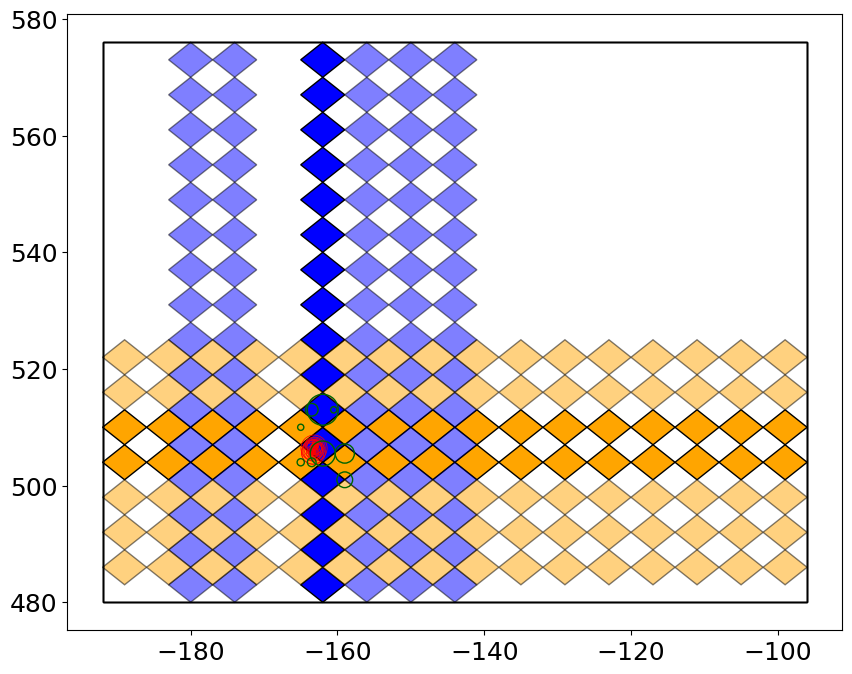

In [25]:
clusterid, x_nonzero, y_nonzero, z_nonzero, q_nonzero = [], [], [], [], []
for ipar in range(int(len(m_coll.values)/2)):
   if m_coll.values[ipar*2+1] != 0:
    clusterid.append(ipar)
    z_nonzero.append(m_coll.values[ipar*2])
    q_nonzero.append(m_coll.values[ipar*2+1]) 
for i in clusterid:
   x_nonzero.append(xpos_fine[i])
   y_nonzero.append(ypos_fine[i])
   
   
q_nonzero = np.array(q_nonzero)   
print(z_nonzero)
fitPos = {'x': x_nonzero, 'y':y_nonzero, 'q':q_nonzero}

nexo_loader._plot_topo2d(evtid, truthPos=True, fitPos=fitPos)


  0%|          | 0/3 [00:00<?, ?it/s]

During minuit construction, there are 40 clusters.
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.259639 > 0
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0245765
W VariableMetricBuilder gdel = -67.2157
W VariableMetricBuilder Call limit exceeded
W VariableMetricBuilder FunctionMinimum is invalid, reached function call limit
Parameters : [4, 5, 6, 7, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 78, 79]  are fixed in this fitting routine.
During minuit construction, there are 40 clusters.
Parameters : [4, 5, 6, 7, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77,

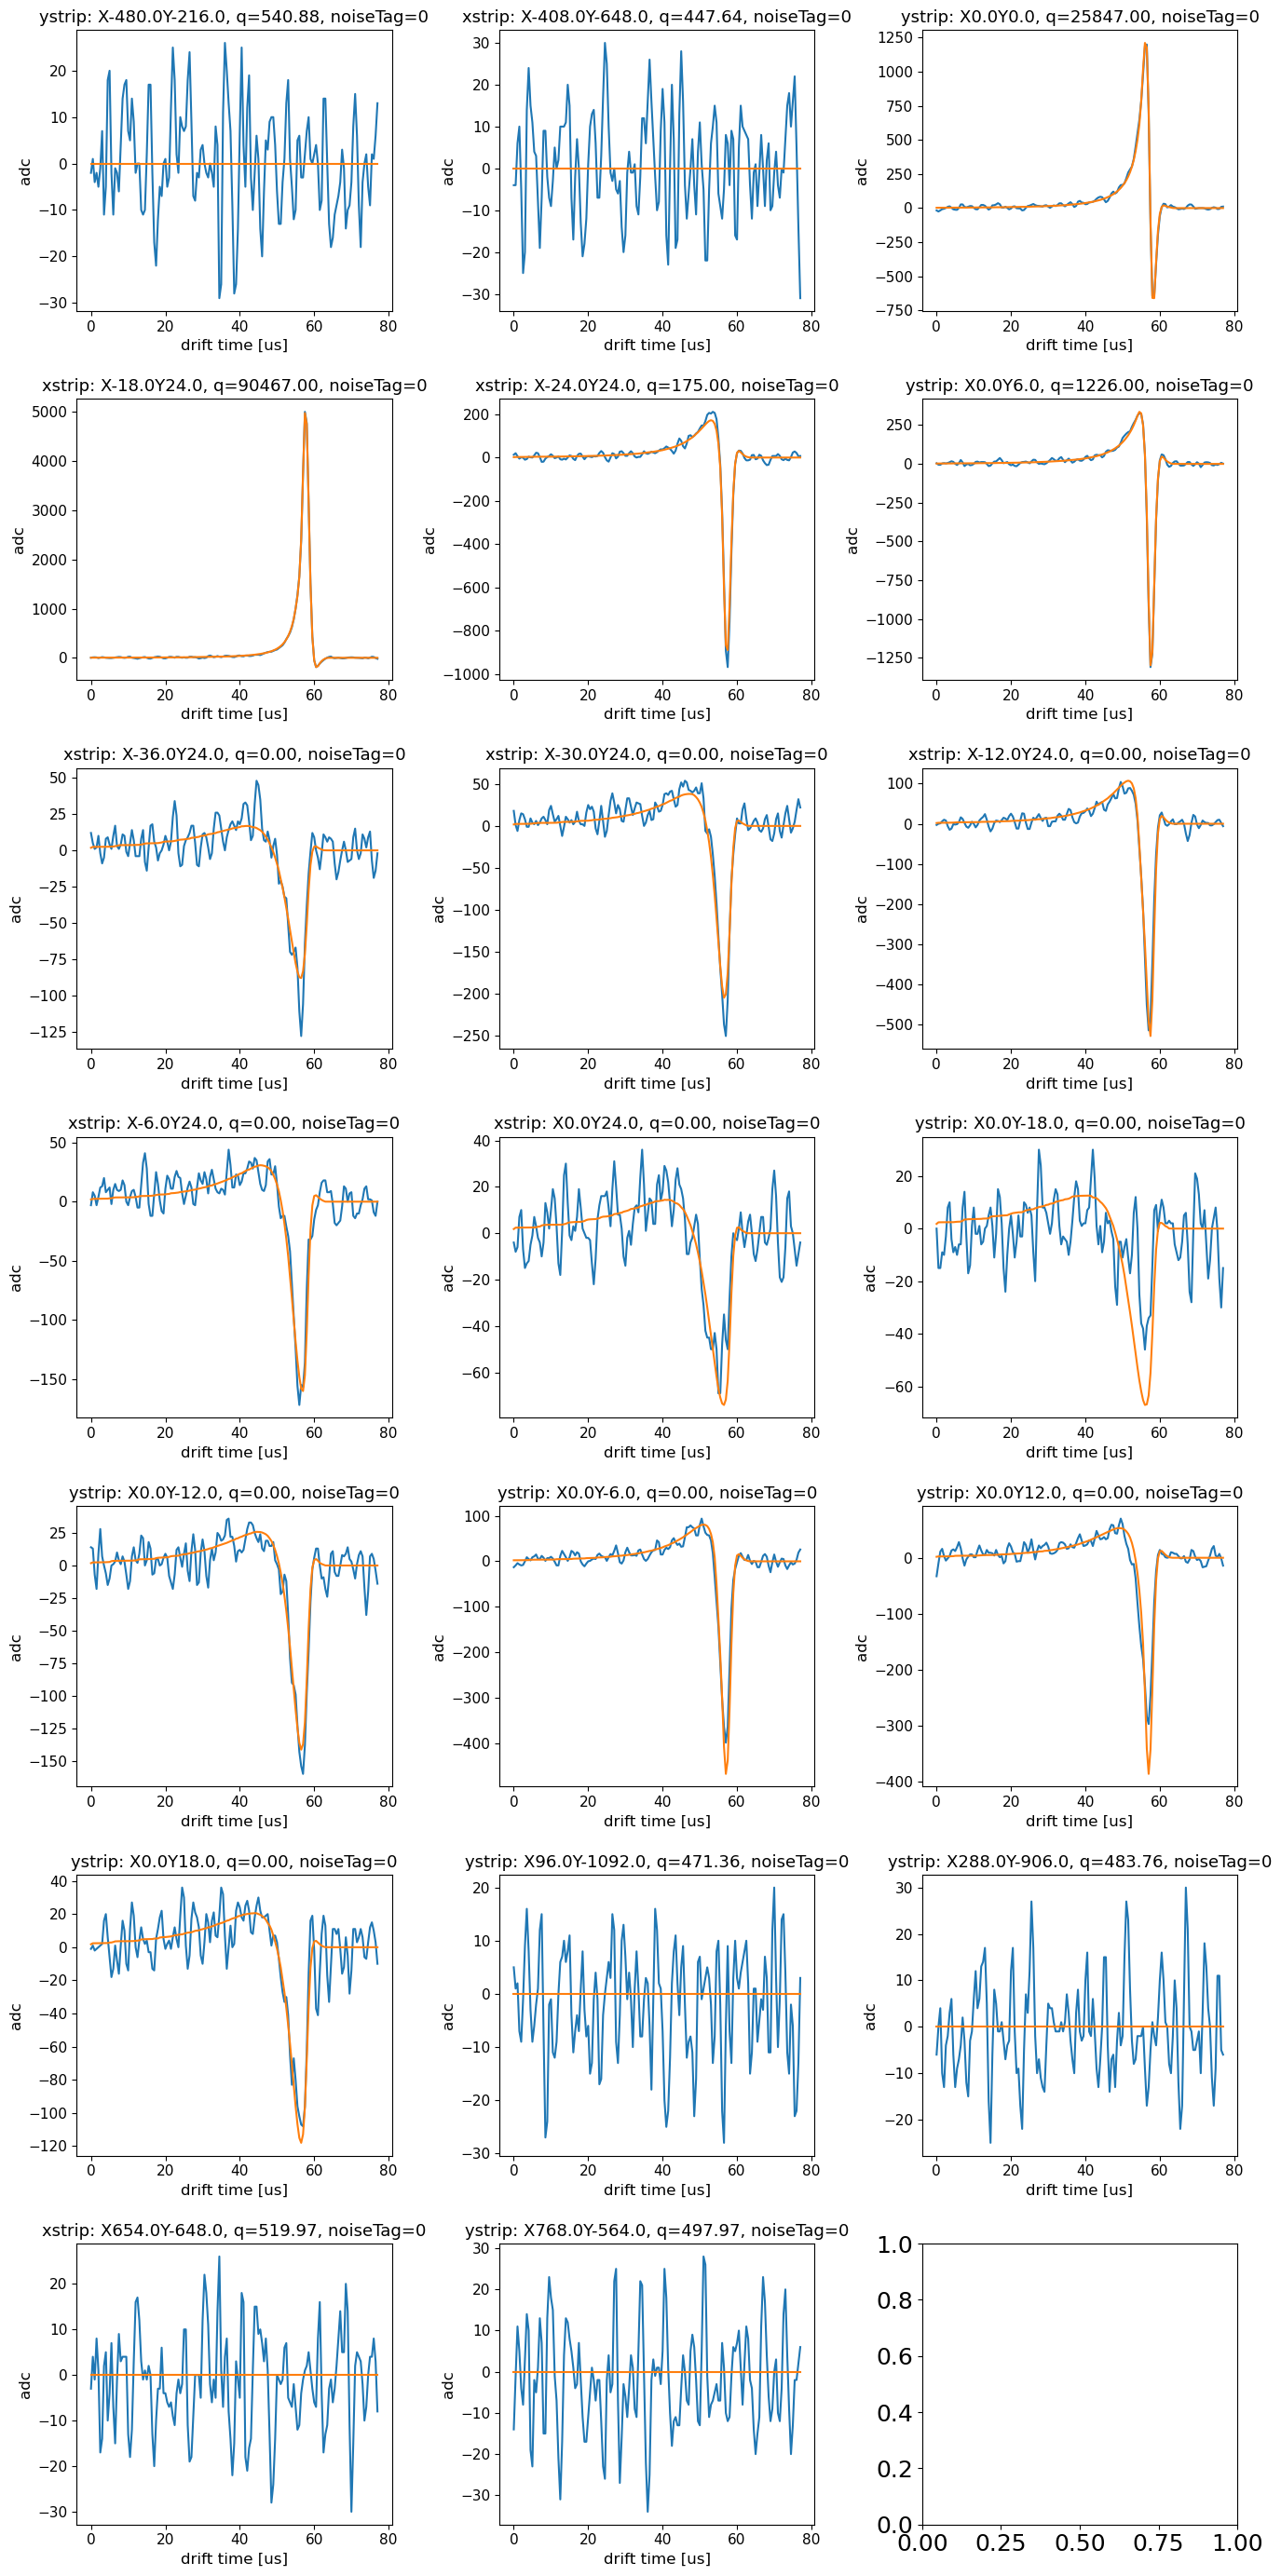

In [31]:
from tqdm.notebook import tqdm
n_param = 2
fixedPar = []
for i in tqdm(range(3)):
    m = fit.multiCluster_fitting(times, wfs, xpos_fine, ypos_fine, init_par, strip_x, strip_y, ystrips, fixedNo=fixedPar)
    init_par = m.values

    fixedPar = []
    for ipar in range(int(len(init_par)/n_param)):
        val = init_par[ipar*n_param+1]
        if val < 1e-2:
            init_par[ipar*n_param+1] = 0.0 # set charge as 0 if it is too small
            fixedPar.append(ipar*n_param+0)
            fixedPar.append(ipar*n_param+1)
    print('Parameters ', end=': ')
    print(fixedPar, end=' ')
    print(' are fixed in this fitting routine.')

fit_params = m.values
fit.multiCluster_manualtuning(times, wfs, xpos_fine, ypos_fine, fit_params, strip_x, strip_y, ystrips, qs, tag)

In [32]:
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4491                       │             Nfcn = 1127              │
│ EDM = 0.00159 (Goal: 0.0002)     │           time = 108.5 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   93.88   │   0.21    │            │            │ 73.8781 │ 113.878 │       │
│ 1 │ x1   │  0.0448   │  0.0031   │            │            │    0    │    2    │       │
│ 2 │ x2   │   93.75   │   0.10    │            │            │ 73.7531 │ 113.753 │       │
│ 3 │ x3   │   0.100   │   0.004   │            │            │    0    │    2    │       │
│ 4 │ x4   │   89.7    │    0.9    │            │            │ 69.686  │ 109.686 │  yes  │
│ 5 │ x5   │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 6 │ x6   │   108.2   │    1.1    │            │            │ 88.2031 │ 128.203 │  yes  │
│ 7 │ x7   │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 8 │ x8   │   59.1    │    0.6    │            │            │ 39.1273 │ 79.1273 │  yes  │
│ 9 │ x9   │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 10│ x10  │   95.9    │    1.0    │            │            │ 75.9471 │ 115.947 │  yes  │
│ 11│ x11  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 12│ x12  │   92.28   │   0.09    │            │            │ 72.2758 │ 112.276 │       │
│ 13│ x13  │   0.040   │   0.004   │            │            │    0    │    2    │       │
│ 14│ x14  │  95.937   │   0.026   │            │            │ 75.9378 │ 115.938 │       │
│ 15│ x15  │  0.1172   │  0.0028   │            │            │    0    │    2    │       │
│ 16│ x16  │   99.1    │    1.0    │            │            │ 79.1007 │ 119.101 │  yes  │
│ 17│ x17  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 18│ x18  │   109.3   │    1.1    │            │            │ 89.2918 │ 129.292 │  yes  │
│ 19│ x19  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 20│ x20  │   114.6   │    1.2    │            │            │ 94.6167 │ 134.617 │  yes  │
│ 21│ x21  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 22│ x22  │  95.664   │   0.017   │            │            │ 75.6637 │ 115.664 │       │
│ 23│ x23  │   0.530   │   0.007   │            │            │    0    │    2    │       │
│ 24│ x24  │   107.3   │    1.1    │            │            │ 87.2724 │ 127.272 │  yes  │
│ 25│ x25  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 26│ x26  │   94.8    │    0.9    │            │            │ 74.8335 │ 114.833 │  yes  │
│ 27│ x27  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 28│ x28  │   89.2    │    0.9    │            │            │ 69.1924 │ 109.192 │  yes  │
│ 29│ x29  │    0.0    │    0.1    │            │            │    0    │    2    │  yes  │
│ 30│ x30  │   111.1   │    1.1    │            │            │ 91.0816 │ 131.082 │  y

In [33]:

n_param = 2
n_cluster = int(len(init_par)/n_param)
sum_charge, sum_charge_err = 0, 0
sum_charge_coll, sum_charge_err_coll = 0, 0

for i in range(n_cluster):
    val = m.values[f'x{1+i*n_param}']
    err = m.errors[f'x{1+i*n_param}']
    if val == 0:
        err = 0.0
    val_coll = m_coll.values[f'x{1+i*n_param}']
    err_coll = m_coll.errors[f'x{1+i*n_param}']
    if val_coll == 0:
        err_coll = 0
    
    sum_charge += val
    sum_charge_err += err**2
    sum_charge_coll += val_coll
    sum_charge_err_coll += err_coll**2
    
    print(f'Fit {i} cluster has charge {val_coll*1e5:.3f} +- {err_coll*1e5:.3f} (collection only) ==> {val*1e5:.3f} +- {err*1e5:.3f} (collection + induction).')


sum_charge_err = np.sqrt(sum_charge_err)
sum_charge_err_coll = np.sqrt(sum_charge_err_coll)

q_truth = np.sum(qs_coll)



print('\n==========================\n')
print(f'Truth charge in this event is {q_truth:.3f}.')
print(f'Total charge for this event is {sum_charge_coll*1e5:.3f} +- {sum_charge_err_coll*1e5:.3f}, energy resolution is {sum_charge_err_coll/sum_charge_coll*100:.3f}% (collection only).')
print(f'Total charge for this event is {sum_charge*1e5:.3f} +- {sum_charge_err*1e5:.3f}, energy resolution is {sum_charge_err/sum_charge*100:.3f}% (collection + induction).')
print('==========================\n')

Fit 0 cluster has charge 0.000 +- 0.000 (collection only) ==> 4478.831 +- 314.169 (collection + induction).
Fit 1 cluster has charge 0.000 +- 0.000 (collection only) ==> 9985.875 +- 410.750 (collection + induction).
Fit 2 cluster has charge 2681.434 +- 213.303 (collection only) ==> 0.000 +- 0.000 (collection + induction).
Fit 3 cluster has charge 0.000 +- 0.000 (collection only) ==> 0.000 +- 0.000 (collection + induction).
Fit 4 cluster has charge 0.000 +- 0.000 (collection only) ==> 0.000 +- 0.000 (collection + induction).
Fit 5 cluster has charge 0.000 +- 0.000 (collection only) ==> 0.000 +- 0.000 (collection + induction).
Fit 6 cluster has charge 3924.553 +- 756.868 (collection only) ==> 4033.773 +- 444.749 (collection + induction).
Fit 7 cluster has charge 0.000 +- 0.000 (collection only) ==> 11722.253 +- 283.685 (collection + induction).
Fit 8 cluster has charge 0.000 +- 0.000 (collection only) ==> 0.000 +- 0.000 (collection + induction).
Fit 9 cluster has charge 0.000 +- 0.000 (c

[93.87825646167566, 93.75297231521695, 92.27681350547824, 95.93747570564253, 95.66376945200957, 90.41814663461244, 93.63387623814877, 94.98484346135962, 91.50000074129126, 91.14941224619616]
-163.31162859062428 505.8185429899386 -500.47568076177055


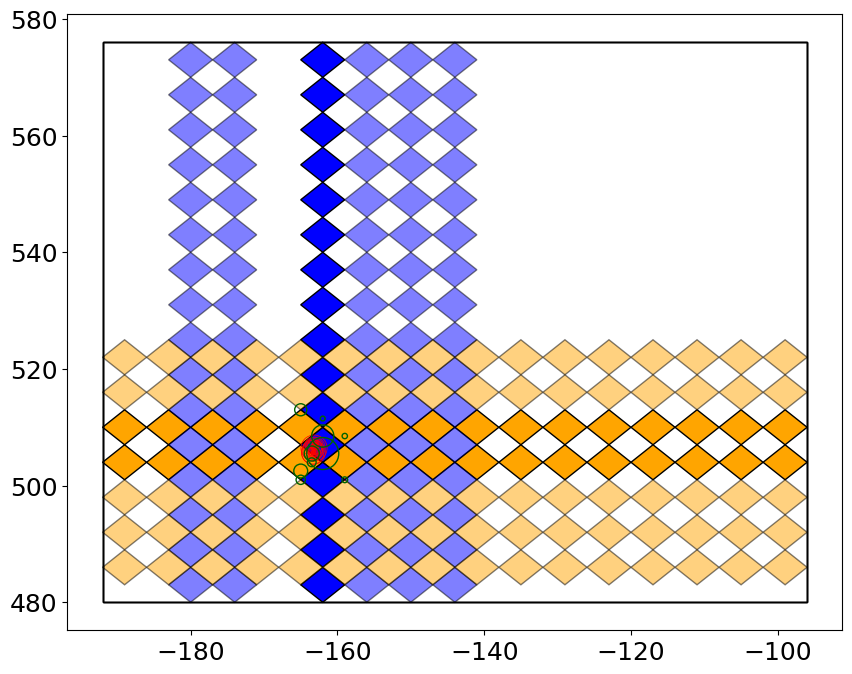

In [34]:
clusterid, x_nonzero, y_nonzero, z_nonzero, q_nonzero = [], [], [], [], []
for ipar in range(int(len(m.values)/2)):
   if m.values[ipar*2+1] != 0:
    clusterid.append(ipar)
    z_nonzero.append(m.values[ipar*2])
    q_nonzero.append(m.values[ipar*2+1]) 
for i in clusterid:
   x_nonzero.append(xpos_fine[i])
   y_nonzero.append(ypos_fine[i])
   
   
q_nonzero = np.array(q_nonzero)   
print(z_nonzero)
fitPos = {'x': x_nonzero, 'y':y_nonzero, 'q':q_nonzero}

nexo_loader._plot_topo2d(evtid, truthPos=True, fitPos=fitPos)
